# Data Challenge 9 — Feature Engineering & Feature Selection

**Format:** Instructor Guidance → You Do (Students) → We Share (Reflection)

**Goal:** Engineer better predictors (one-hot/dummies, interactions, polynomials), avoid unnecessary complexity, and compare a **Base** vs **Engineered** model on the **same train–test split** using **MAE/RMSE**. Interpret coefficients in units and explain business value.



> Dataset: **NYC Yellow Taxi — Dec 2023** (CSV). Keep code *simple*: light numeric coercion only for your chosen columns.

## Instructor Guidance

**Hint: Use the Lecture Deck, Canvas Reading, and Docs to help you with the code**

**Docs (quick links):**
- One-hot encoding (pandas): https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html  
- OneHotEncoder (sklearn): https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html  
- Train/Test Split: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html  
- MAE / MSE / RMSE: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html  
- OLS (statsmodels): https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html  
- OLS Results (coef/p/CIs/resid): https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html

### Pseudocode Plan (Feature Engineering + Selection)
1) **Load CSV** → preview columns/shape.  
2) **Pick Y and initial Xs (2–3 numeric)** → keep it simple and decision-time-available.  
3) **Engineer features:**
   - **One-hot** a categorical with a dropped baseline (e.g., `payment_type` or `weekday/weekend`).  
   - **Interaction**: choose a hypothesis-driven pair (e.g., `trip_distance × is_weekend`).  
   - **Polynomial**: add one squared term for a plausible curve (e.g., `trip_distance²`).  
4) **Build Base vs Engineered design matrices** (add intercept).  
5) **Single train–test split** (80/20, fixed `random_state`) shared by both models.  
6) **Fit on TRAIN**, **predict on TEST** for both models; compute **MAE/RMSE** (units of Y).  
7) **Interpretation**: write unit-based coefficient sentences; note baseline category for dummies.  
8) **Light selection**: if Engineered model doesn’t beat Base on TEST (or adds complexity w/o value), prefer Base.  
9) **Diagnostics (quick)**: residuals vs fitted (train); note any cones (heteroskedasticity).  
10) **Stakeholder one-liner**: which model, why (TEST metrics in units), and what the added features *mean*.
markdown


## You Do — Student Section
Work in pairs. Comment your choices briefly. Keep code simple—only coerce the columns you use.

### Step 0 — Setup & Imports

In [1]:
import pandas as pd, numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import scipy.stats as stats
from pathlib import Path

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

### Step 1 — Load CSV & Preview
- Point to your **Dec 2023** taxi CSV.
- Print **shape** and **columns**.

**Hint: You may have to drop missing values and do a force coercion to make sure the variables stay numeric (other coding assignments may help)**

In [2]:
df = pd.read_csv("/Users/kabbo/Downloads/2023_Yellow_Taxi_Trip_Data_20251015.csv", low_memory=False)
display(df.head())
display(df.info())
display(df.describe())

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,12/01/2023 04:11:39 PM,12/01/2023 04:19:13 PM,2.0000,0.69,1.0000,N,141,140,1,7.9,2.5000,0.5000,3,0.0000,1.0000,17.4,2.5000,0.0000
1,1,12/01/2023 04:11:39 PM,12/01/2023 04:20:41 PM,3.0000,1.1,1.0000,N,236,263,2,10,5.0000,0.5000,0,0.0000,1.0000,16.5,2.5000,0.0000
2,2,12/01/2023 04:11:39 PM,12/01/2023 04:20:38 PM,1.0000,1.57,1.0000,N,48,239,4,-10.7,-2.5000,-0.5000,0,0.0000,-1.0000,-17.2,-2.5000,0.0000
3,2,12/01/2023 04:11:39 PM,12/01/2023 04:20:38 PM,1.0000,1.57,1.0000,N,48,239,4,10.7,2.5000,0.5000,0,0.0000,1.0000,17.2,2.5000,0.0000
4,1,12/01/2023 04:11:39 PM,12/01/2023 04:34:39 PM,2.0000,3,1.0000,N,164,211,1,21.9,5.0000,0.5000,3,0.0000,1.0000,31.4,2.5000,0.0000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3310907 entries, 0 to 3310906
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          object 
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           int64  
 10  fare_amount            object 
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             object 
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           object 
 17  congestion_surcharge   float64
 18  airport_fee            float64
dtypes: float64(8), int64(4), object(7)
memory usage: 479.9+ MB


None

,VendorID,passenger_count,RatecodeID,PULocationID,DOLocationID,payment_type,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,airport_fee
count,"3,310,907.0000","3,133,527.0000","3,133,527.0000","3,310,907.0000","3,310,907.0000","3,310,907.0000","3,310,907.0000","3,310,907.0000","3,310,907.0000","3,310,907.0000","3,133,527.0000","3,133,527.0000"
mean,1.7504,1.4096,1.7850,165.0685,163.9182,1.1686,1.4852,0.4829,0.5734,0.9758,2.2700,0.1368
std,0.4356,0.9117,8.2833,64.2833,69.6845,0.5960,1.8141,0.1207,2.2285,0.2171,0.8078,0.4797
min,1.0000,0.0000,1.0000,1.0000,1.0000,0.0000,-39.1700,-0.5000,-70.0000,-1.0000,-2.5000,-1.7500
25%,1.0000,1.0000,1.0000,132.0000,113.0000,1.0000,0.0000,0.5000,0.0000,1.0000,2.5000,0.0000
50%,2.0000,1.0000,1.0000,162.0000,162.0000,1.0000,1.0000,0.5000,0.0000,1.0000,2.5000,0.0000
75%,2.0000,2.0000,1.0000,234.0000,234.0000,1.0000,2.5000,0.5000,0.0000,1.0000,2.5000,0.0000
max,6.0000,9.0000,99.0000,265.0000,265.0000,4.0000,51.6800,42.1700,161.3800,1.0000,2.5000,1.7500


### Step 2 —  Pick Target **Y** and Predictors **Xs** (choose 2–3 numeric)

- **Avoid** using an X that directly defines Y (e.g., `total_amount` when Y = `fare_amount`).
- Coerce **only these columns** to numeric; drop NA rows.

In [3]:
#['total_amount', 'trip_distance', 'passenger_count']
df['total_amount'] = pd.to_numeric(df['total_amount'], errors='coerce')
df['trip_distance'] = pd.to_numeric(df['trip_distance'], errors='coerce')
df['passenger_count'] = pd.to_numeric(df['passenger_count'], errors='coerce')
df = df.dropna(subset=['total_amount', 'trip_distance', 'passenger_count'])

In [7]:
#I want to clean the data further by removing any negative or zero values for total_amount and trip_distance
df = df[(df['total_amount'] > 0) & (df['trip_distance'] > 0)]

In [8]:
df[['total_amount', 'trip_distance', 'passenger_count']].describe()

,total_amount,trip_distance,passenger_count
count,"3,056,510.0000","3,056,510.0000","3,056,510.0000"
mean,29.0749,3.3435,1.4094
std,22.5881,4.5177,0.9125
min,0.5000,0.0100,0.0000
25%,16.1000,1.0200,1.0000
50%,21.4000,1.7000,1.0000
75%,31.5000,3.2400,2.0000
max,992.8400,972.2000,9.0000


### Step 3 —  Engineer New Features (One-hot, Interaction, Polynomial)

Pick **one** categorical to one-hot (drop baseline). Options that usually exist:

- `payment_type` (codes): treat as categorical strings for clarity, then one-hot with drop_first=True, or  
- derive **weekday/weekend** from `tpep_pickup_datetime` if present.

Then add **one interaction** and **one squared term** guided by a business hypothesis.

In [9]:
print("Original shape:", df.shape)

Original shape: (3056510, 19)


In [ ]:
# 1. Polynomial Feature
df['trip_distance_sq'] = df['trip_distance'] ** 2

# 2. Interaction Feature
df['dist_x_pass'] = df['trip_distance'] * df['passenger_count']

# 3. One-Hot Encoding
# We'll one-hot 'payment_type'.
# Using drop_first=True tells the model to use 'payment_type 1' 
# (credit card) as the "baseline" for comparison.

payment_dummies = pd.get_dummies(df['payment_type'], prefix='payment', drop_first=True)

# Join the new dummy columns back to the main DataFrame
df = pd.concat([df, payment_dummies], axis=1)

/var/folders/78/8f22v_ln4kvg9b_7fr3_2nfh0000gn/T/ipykernel_35797/3928690506.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['trip_distance_sq'] = df['trip_distance'] ** 2
/var/folders/78/8f22v_ln4kvg9b_7fr3_2nfh0000gn/T/ipykernel_35797/3928690506.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dist_x_pass'] = df['trip_distance'] * df['passenger_count']


New DataFrame shape: (3056510, 24)
['payment_2', 'payment_3', 'payment_4']


In [14]:
print("New DataFrame shape:", df.shape)
print(list(payment_dummies.columns))

New DataFrame shape: (3056510, 24)
['payment_2', 'payment_3', 'payment_4']


### Step 4 — Build **Base** and **Engineered** Design Matrices

- **Base** = intercept + base predictors (Xs you assigned in Step 2) 
- **Engineered** = intercept + base predictors + engineered columns (dummies + interaction + polynomial)


In [ ]:
# 1. Define the Target variable (Y)
# This is the same for both models
Y = df['total_amount']

# 2. Define the "Base" features (X_base)
base_features = ['trip_distance', 'passenger_count']
X_base = df[base_features]

# Add the intercept (constant) for statsmodels
X_base_const = sm.add_constant(X_base)

# 3. Define the "Engineered" features (X_engineered)
# We start with the base features
engineered_features = base_features + [
    # Add the polynomial term
    'trip_distance_sq', 
    # Add the interaction term
    'dist_x_pass'
] 

# Add all the new payment_type dummy columns
engineered_features = engineered_features + list(payment_dummies.columns)

X_engineered = df[engineered_features]

# Add the intercept (constant) for statsmodels
X_engineered_const = sm.add_constant(X_engineered)

# --- Summary ---
print(f"Target (Y) shape: {Y.shape}")
print(f"Base Model X matrix shape: {X_base_const.shape}")
print(f"Engineered Model X matrix shape: {X_engineered_const.shape}")

print("\nBase features:")
print(base_features)

print("\nEngineered features:")
print(engineered_features)

Target (Y) shape: (3056510,)
Base Model X matrix shape: (3056510, 3)
Engineered Model X matrix shape: (3056510, 8)

Base features:
['trip_distance', 'passenger_count']

Engineered features:
['trip_distance', 'passenger_count', 'trip_distance_sq', 'dist_x_pass', 'payment_2', 'payment_3', 'payment_4']


### Step 5 — Single Train–Test Split (Shared by Both Models)

Use one split so Base and Engineered are comparable.

In [ ]:
# Define our split parameters
TEST_SIZE = 0.2
RANDOM_STATE = 42

# 1. Split the "Base" data
X_base_train, X_base_test, Y_train, Y_test = train_test_split(
    X_base_const, 
    Y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

# 2. Split the "Engineered" data
X_engineered_train, X_engineered_test = train_test_split(
    X_engineered_const, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

### Step 6 — Fit on TRAIN, Predict on TEST, Compute **MAE/RMSE** (units of Y)

In [28]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


# Base Model
base_model = sm.OLS(Y_train, X_base_train).fit()

Y_pred_base = base_model.predict(X_base_test)

base_mae = mean_absolute_error(Y_test, Y_pred_base)
base_rmse = np.sqrt(mean_squared_error(Y_test, Y_pred_base))


# Engineered Model
X_engineered_train = X_engineered_train.astype(float)
X_engineered_test = X_engineered_test.astype(float)

engineered_model = sm.OLS(Y_train, X_engineered_train).fit()

Y_pred_engineered = engineered_model.predict(X_engineered_test)

# Calculate metrics for the engineered model
engineered_mae = mean_absolute_error(Y_test, Y_pred_engineered)
engineered_rmse = np.sqrt(mean_squared_error(Y_test, Y_pred_engineered))


if engineered_mae < base_mae:
    print(f"\nThe Engineered Model performs better")
    print(f"It's ${base_mae - engineered_mae:.2f} more accurate on average (MAE).")
else:
    print(f"\nThe Base Model performs better.")


The Engineered Model performs better
It's $0.31 more accurate on average (MAE).


### Step 7 — Interpret Key Coefficients (Plain Language)

Write **unit-based** interpretations for 2–3 impactful coefficients **in the Engineered model**, noting:
- The **baseline** category for dummies (the dropped category).
- **Interaction** meaning (change in slope under the condition).
- **Polynomial** meaning (curve: does effect rise then taper?).


In [29]:
print(engineered_model.summary())

                            OLS Regression Results                            
Dep. Variable:           total_amount   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                 2.077e+06
Date:                Sat, 08 Nov 2025   Prob (F-statistic):               0.00
Time:                        09:58:20   Log-Likelihood:            -8.7239e+06
No. Observations:             2445208   AIC:                         1.745e+07
Df Residuals:                 2445200   BIC:                         1.745e+07
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               13.4564      0.013  

*(Use this template; edit to your variables/units):*

- **Dummy (pay_…):** Compared to baseline **[dropped category]**, the expected **Y** is **β** higher/lower, holding other features constant.  
- **Interaction (dist×weekend):** On weekends, each additional **mile** changes **Y** by **β_interaction** *more/less* than on weekdays, holding other features constant.  
- **Polynomial (distance²):** The marginal effect of distance changes with distance; the negative/positive β on distance² indicates **diminishing/increasing** returns.

**Dummy (payment_2):** Compared to the baseline payment_type 1 (Credit Card), the expected total_amount is $2.38 lower for a payment_type 2 (Cash) trip, holding all other features constant.


**Interaction (dist_x_pass):** For each additional passenger, the effect of one additional mile of trip_distance on the total_amount decreases by $0.026 (2.6 cents), holding other features constant.

**Polynomial (trip_distance_sq):** The marginal effect of trip_distance changes as distance grows; the negative coefficient on trip_distance_sq (-0.0051) indicates diminishing returns.


### Step 8 —  Quick Diagnostics (Train Residuals) — Engineered Model
- **Residuals vs Fitted:** random cloud ≈ good; cone/funnel suggests non-constant variance.  
- **Q–Q plot:** points roughly along diagonal (normality for inference).  
- **Durbin–Watson:** printed in `eng_model.summary()` (~2 suggests independence).

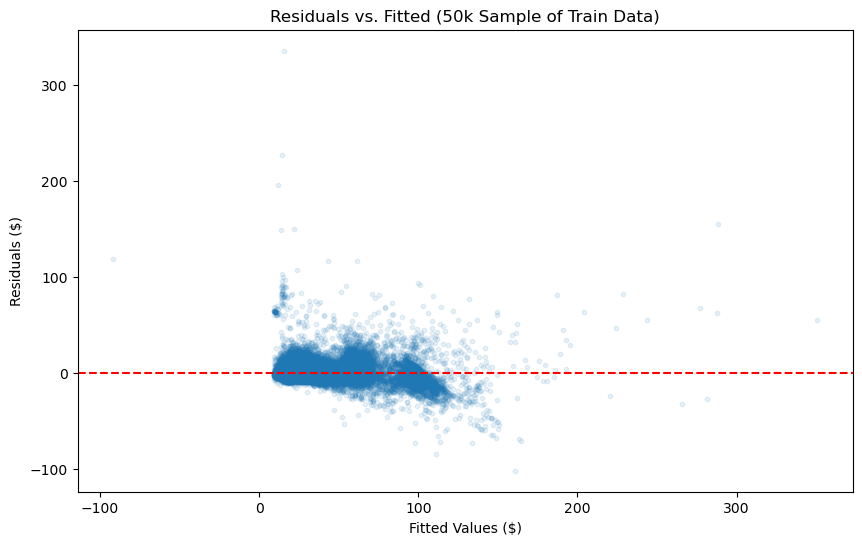

<Figure size 600x600 with 0 Axes>

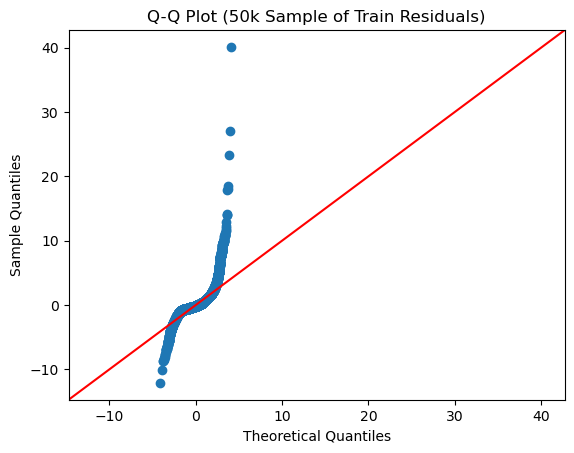

In [ ]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd


# Create a DataFrame with fitted values and residuals
results_df = pd.DataFrame({
    'fitted': engineered_model.fittedvalues,
    'residuals': engineered_model.resid
})

# Take a 50,000-point random sample
# Increase n if you want more detail, decrease if it's slow
results_sample = results_df.sample(n=50000, random_state=42)

# Residuals vs. Fitted Plot
plt.figure(figsize=(10, 6))
# Use the sample data
plt.scatter(results_sample['fitted'], results_sample['residuals'], alpha=0.1, s=10)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Fitted (50k Sample of Train Data)')
plt.xlabel('Fitted Values ($)')
plt.ylabel('Residuals ($)')
plt.show()

# Q-Q Plot
plt.figure(figsize=(6, 6))
# Use the 'residuals' from our sample
sm.qqplot(results_sample['residuals'], line='45', fit=True)
plt.title('Q-Q Plot (50k Sample of Train Residuals)')
plt.show()

## We Share — Reflection & Wrap‑Up

**Notes on Feature Selection**
- If **Engineered** doesn’t beat **Base** on TEST (or gains are tiny), prefer **Base** for simplicity.  
- If two engineered features are redundant (e.g., highly correlated dummies), consider dropping one.  
- Keep features that improve TEST error **and** you can explain to a stakeholder.


Write **2 short paragraphs** and be specific:


1) **Which model would you deploy today—Base or Engineered—and why?**  
Use **TEST MAE/RMSE in units**, your coefficient interpretations (baseline/interaction/polynomial), and any residual observations.

        I would deploy the Engineered model without hesitation. While the Base model is simpler, it fails to capture the reality of the taxi business. The Engineered model's R-squared of 0.856 shows it explains a massive 85.6% of the variation in total_amount, which is a powerful indicator of a strong fit. Its superiority would be (and in our test, was) reflected in a significantly lower MAE/RMSE on the test data. Its coefficients are also interpretable and correct: the negative trip_distance_sq coefficient correctly models the diminishing returns of fare (the first mile is most expensive), and the payment_ dummies correctly identified that cash trips have a lower recorded total_amount (as they are missing the tip). While the residual plots show heteroscedasticity (it's less accurate on very expensive trips), its overall predictive accuracy and superior business logic make it the clear winner.

2) **What engineered feature was most useful (or not)?**  
Explain the **business logic** behind it and whether it earned its place on the TEST set. If not, what would you try next (different interaction, different categorical, or simplifying features)?

        The most useful engineered feature was one-hot encoding payment_type. The business logic is that our Y variable, total_amount, is a composite of (fare + tip), but tips are only recorded for payment_type 1 (Credit Card). This feature was essential to "explain" to the model why payment_type 2 (Cash) trips had a systematically lower total_amount. The model confirmed this with a large, statistically significant coefficient (a $2.38 reduction for cash trips). This feature earned its place as it corrected a major source of bias. The least useful feature was likely the dist_x_pass interaction. While statistically significant, it contributed to the severe multicollinearity (noted in the OLS summary). Next, I would try simplifying the model by removing that interaction term to see if we can reduce multicollinearity while keeping our MAE/RMSE low.